In [78]:
import pandas as pd
import requests
import os
from datetime import datetime
import time 
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
import seaborn as sns
import importlib
import metrics_calculations
importlib.reload(metrics_calculations)
from metrics_calculations import calculate_stock_metrics_for_summary_portfolio, calculate_metrics_for_each_stock, calculate_beta_stock

In [79]:
#Load enviroment variable from .env file 
load_dotenv()
api_key = os.getenv('API_KEY')
#server connection
server = os.getenv('SERVER')
database = os.getenv("DATABASE")

Requesting a stock data from polygon io and clean the data

In [80]:
#Collection of stock ticker 
stock_ticker = ["SONY", "JPM", "SHEL", "WMT", "HMC"]

In [81]:
#Method to request stock data from polygon io 
def get_stock_etf_data(ticker, api_key):
    start_date = "2023-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')
    #End point from polygon io
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {
        "adjusted": "true",
        "sort": "asc",
        "limit": "50000",
        "apiKey": api_key
    }
    #Sending get request
    responce = requests.get(url=base_url, params=params)
    data = responce.json()
    if "results" in data:
        #Saving the result in data frame 
        df = pd.DataFrame(data["results"])
        df['ticker'] = ticker
        df['date'] = pd.to_datetime(df['t'], unit='ms').dt.date
        return df[['ticker', 'date', 'o', 'h', 'l', 'c', 'v']]
    else:
        print(f"No data found")
        return pd.DataFrame()


In [82]:
#Calling the get_stock_etf_data method for the five stocks and one etf 
ticker_df = []
for ticker in stock_ticker:
    df = get_stock_etf_data(ticker=ticker, api_key=api_key)
    ticker_df.append(df)
#Running the polygon api after 60 seconds 
time.sleep(60)
#ETF - vanguard growth index fund ETF
ETF_ticker = 'VUG'
df = get_stock_etf_data(ticker=ETF_ticker, api_key=api_key)
ticker_df.append(df)
print('Done running ETF')

Done running ETF


In [83]:
stocks_data = pd.concat(ticker_df)
stocks_data.columns = ["Symbol","Date","Open","High","Low","Close","Volume"]
stocks_data.sample(5)

,Symbol,Date,Open,High,Low,Close,Volume
169,VUG,2023-09-06,289.09,289.320,285.4150,286.96,635509.0
112,SONY,2023-06-14,100.71,100.890,99.5100,99.87,515116.0
164,JPM,2023-08-29,147.71,148.850,147.1800,148.76,6336962.0
397,WMT,2024-08-02,69.60,70.235,67.7400,68.46,22986279.0
227,SONY,2023-11-28,86.70,87.610,86.4013,87.23,1169322.0


Start Cleaning the data 

In [84]:
#Checking for the datatypes 
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2442 entries, 0 to 406
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  2442 non-null   object 
 1   Date    2442 non-null   object 
 2   Open    2442 non-null   float64
 3   High    2442 non-null   float64
 4   Low     2442 non-null   float64
 5   Close   2442 non-null   float64
 6   Volume  2442 non-null   float64
dtypes: float64(5), object(2)
memory usage: 152.6+ KB


In [85]:
#Checking if there is null value
stocks_data.isnull().mean() * 100

Symbol    0.0
Date      0.0
Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64

In [86]:
#Checking for duplicate
duplicate = stocks_data[stocks_data.duplicated()]
duplicate

,Symbol,Date,Open,High,Low,Close,Volume


In [87]:
#Clean data - Change string date to Date data type 
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'], format='%Y-%m-%d')
#Change the volume to INT 
#Volume is number shares traded during the day (Can't buy or sale fraction share on the stock market)
stocks_data['Volume'] = stocks_data['Volume'].astype(int)
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2442 entries, 0 to 406
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Symbol  2442 non-null   object        
 1   Date    2442 non-null   datetime64[ns]
 2   Open    2442 non-null   float64       
 3   High    2442 non-null   float64       
 4   Low     2442 non-null   float64       
 5   Close   2442 non-null   float64       
 6   Volume  2442 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 152.6+ KB


In [88]:
#Change the column names to lower case 
original_columns = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']
new_columns = [col.lower().replace(' ','_') for col in original_columns]
stocks_data.columns = new_columns
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2442 entries, 0 to 406
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  2442 non-null   object        
 1   date    2442 non-null   datetime64[ns]
 2   open    2442 non-null   float64       
 3   high    2442 non-null   float64       
 4   low     2442 non-null   float64       
 5   close   2442 non-null   float64       
 6   volume  2442 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 152.6+ KB


Feature Engineering to stock_data

In [89]:
#Calculate 10 day and 100 day moving average and feature engineering 
stocks_data['10_days_moving_average'] = stocks_data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10).mean()).fillna(0)
stocks_data['100_days_moving_average'] = stocks_data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=100).mean()).fillna(0)


In [90]:

stock_ticker.append(ETF_ticker)

In [91]:
#Calculate the investoment ammount for stocks and add it to stock_data
inital_investment = 100000/len(stock_ticker)
invested_amount_df = pd.DataFrame()
for s in stock_ticker:
    #Calculate the invested amount and daily change for each stock
    stock_df = stocks_data[stocks_data['symbol'] == s].copy()
    stock_df['investment_value'] = (inital_investment / stock_df['close'].iloc[0]) * stock_df['close']
    stock_df['daily_change'] = stock_df['investment_value'].diff()
    invested_amount_df = pd.concat([invested_amount_df, stock_df[['symbol', 'date', 'close', 'investment_value', 'daily_change']]])
invested_amount_df.reset_index(drop=True, inplace=True)
invested_amount_df['daily_change'] = invested_amount_df['daily_change'].fillna(0)

invested_amount_df[invested_amount_df['symbol'] == 'SONY'].head(10)


,symbol,date,close,investment_value,daily_change
0,SONY,2023-01-03,76.65,16666.666667,0.000000
1,SONY,2023-01-04,77.80,16916.721026,250.054360
2,SONY,2023-01-05,77.50,16851.489454,-65.231572
3,SONY,2023-01-06,81.39,17697.325506,845.836051
4,SONY,2023-01-09,82.62,17964.774951,267.449446
5,SONY,2023-01-10,82.08,17847.358121,-117.416830
6,SONY,2023-01-11,84.29,18327.897369,480.539248
7,SONY,2023-01-12,86.07,18714.938030,387.040661
8,SONY,2023-01-13,85.75,18645.357686,-69.580344
9,SONY,2023-01-17,86.76,18864.970646,219.612959


In [92]:
invested_amount_df[invested_amount_df['symbol'] == 'SONY'].tail(10)

,symbol,date,close,investment_value,daily_change
397,SONY,2024-08-02,81.61,17745.161992,-721.896064
398,SONY,2024-08-05,82.38,17912.589693,167.427702
399,SONY,2024-08-06,83.05,18058.273538,145.683844
400,SONY,2024-08-07,84.56,18386.605784,328.332246
401,SONY,2024-08-08,84.43,18358.338769,-28.267015
402,SONY,2024-08-09,84.40,18351.815612,-6.523157
403,SONY,2024-08-12,84.72,18421.395956,69.580344
404,SONY,2024-08-13,89.06,19365.079365,943.683409
405,SONY,2024-08-14,88.99,19349.858665,-15.220700
406,SONY,2024-08-15,88.46,19234.616221,-115.242444


Calculate top metrics 

In [93]:
#Calculate top metrics for individual stocks 
invested_grouped = invested_amount_df.groupby('symbol')
stock_portfolio = invested_grouped.apply(calculate_metrics_for_each_stock).apply(pd.Series)
#Calculate the beta for the stocks
stocks_data_grouped = stocks_data.groupby('symbol')
beta_data = stocks_data_grouped.apply(calculate_beta_stock).apply(pd.Series)
#merging two dfs together(stock_portfolio and beta_data)
individual_stock_portfolio = pd.merge(stock_portfolio, beta_data, on='symbol', how='inner')
individual_stock_portfolio


C:\Users\seifu\AppData\Local\Temp\ipykernel_22060\305840231.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stock_portfolio = invested_grouped.apply(calculate_metrics_for_each_stock).apply(pd.Series)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\seifu\AppData\Local\Temp\ipykernel_22060\305840231.py:6: DeprecationWarning: D

,total_return,cumulative_return,volatility,10_days_ma,100_days_ma,sharp_ratio,beta
symbol,,,,,,,
HMC,6016.330039,36.097980,21.996296,29.869,33.1512,0.858746,0.795268
JPM,9427.422538,56.564535,20.650841,204.056,199.6546,1.441882,0.783096
SHEL,5117.899250,30.707395,19.625479,71.609,71.5666,0.811148,0.485357
SONY,2567.949554,15.407697,25.660530,85.166,84.7967,0.281407,0.897549
VUG,12659.294614,75.955768,17.348294,354.774,356.1574,2.282384,1.262065
WMT,8813.816982,52.882902,16.776063,68.498,64.9797,1.660702,0.348768


In [94]:
#Save the portfolio summary
portfolio_summary = pd.DataFrame([calculate_stock_metrics_for_summary_portfolio(stock_portfolio)])
portfolio_summary

,total_return,cumulative_return,annulized_return,volatilty,sharp_ratio
0,44602.712977,44.602713,25.484734,20.342917,0.011544


In [95]:
#Calculating the average values for each stocks close price 
#group the data by symbole 
stock_groupeddata = stocks_data.groupby('symbol')
average_price = stock_groupeddata['close'].mean()
average_price

symbol
HMC      30.917002
JPM     162.642973
SHEL     64.425971
SONY     88.182604
VUG     297.447125
WMT      55.288717
Name: close, dtype: float64

Save the data into SQL \
    -stocks_data\
    -invested_amount_df\
    -individual_stock_portfolio\
    -portfolio_summary
    
    

In [96]:
#creating an engine
engine = create_engine(f'mssql+pymssql://@{server}/{database}')

#save data frame to sql
stocks_data.to_sql('stocks_data_table', engine, if_exists='replace', index=False)
invested_amount_df.to_sql('invested_amount_table', engine, if_exists='replace', index=False)
individual_stock_portfolio.to_sql('individual_stock_portfolio_table', engine, if_exists='replace', index=False)
portfolio_summary.to_sql('portfolio_summary_table', engine, if_exists='replace', index=False)

#close connection
engine.dispose

<bound method Engine.dispose of Engine(mssql+pymssql://@adejene/stock_analysisDB)>

Visualization 

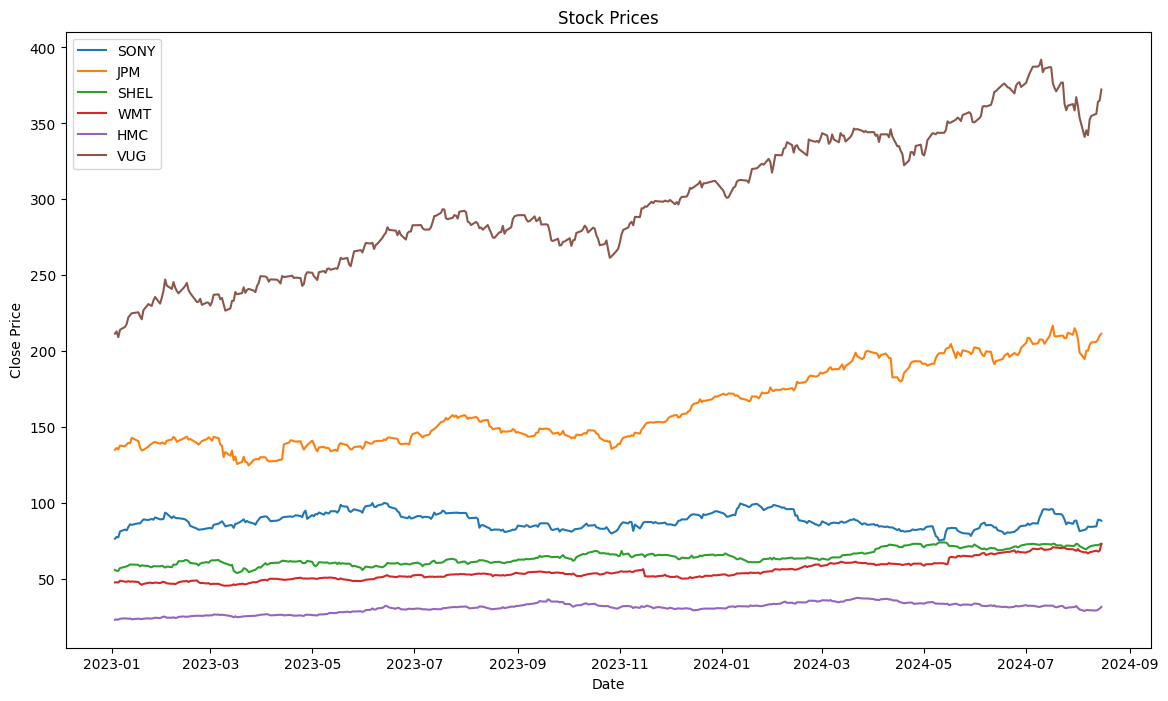

In [97]:
#Line plot to check the close price for each stocks over days, performance visualization 
plt.figure(figsize=(14,8))
stock_checked = []
for symbol in stocks_data['symbol']:
    if symbol not in stock_checked:
        stock_data = stocks_data[stocks_data['symbol'] == symbol]
        plt.plot(stock_data['date'], stock_data['close'], label=symbol) 
        stock_checked.append(symbol)
plt.title("Stock Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

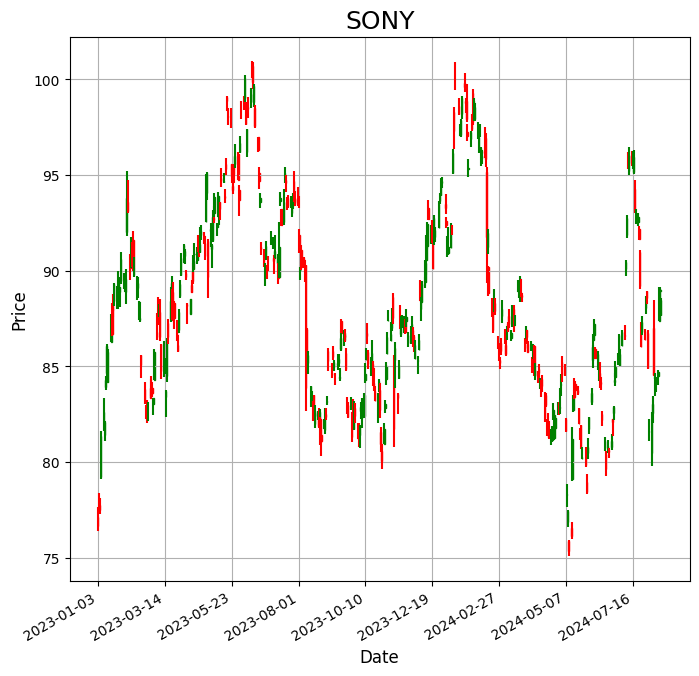

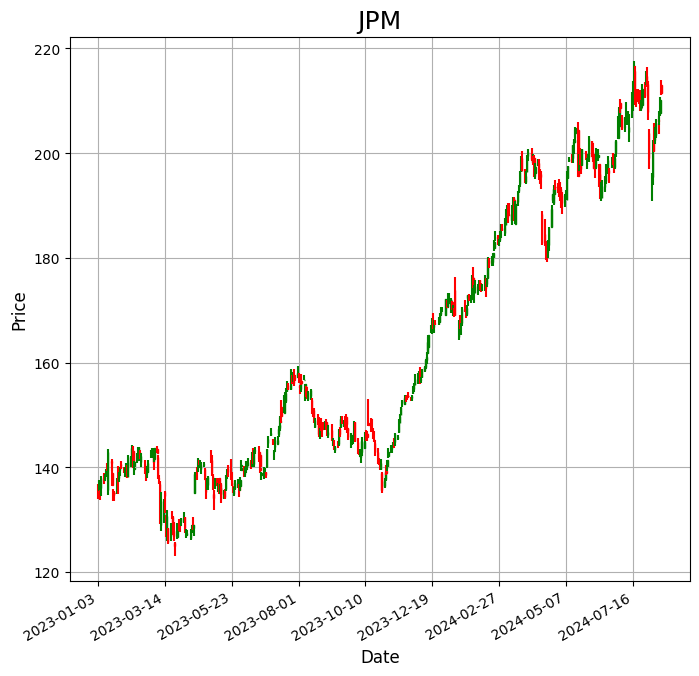

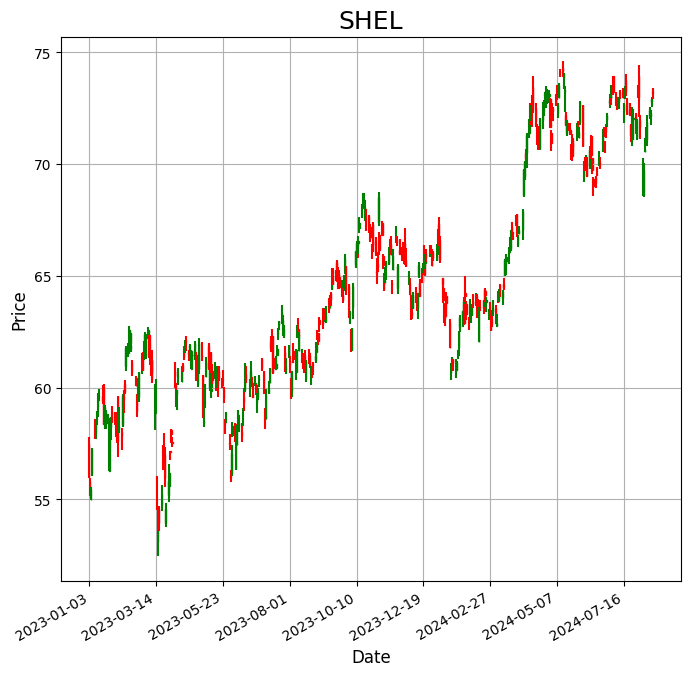

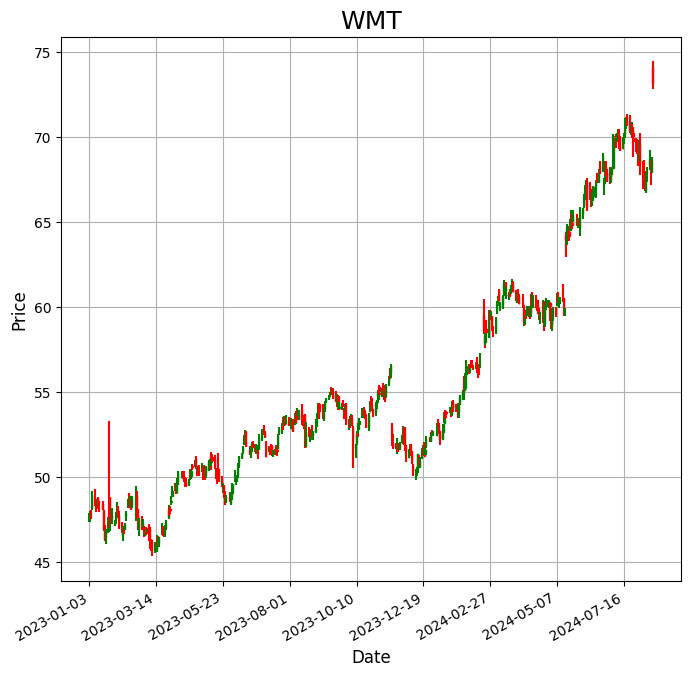

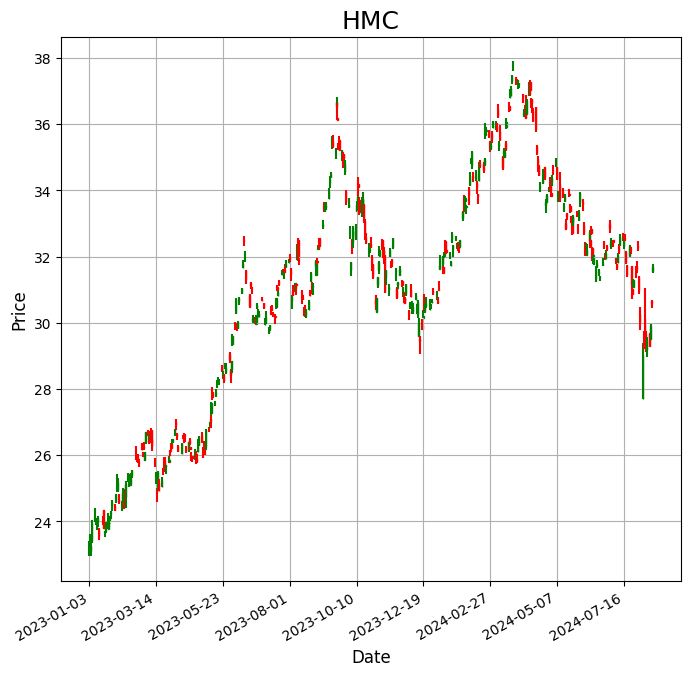

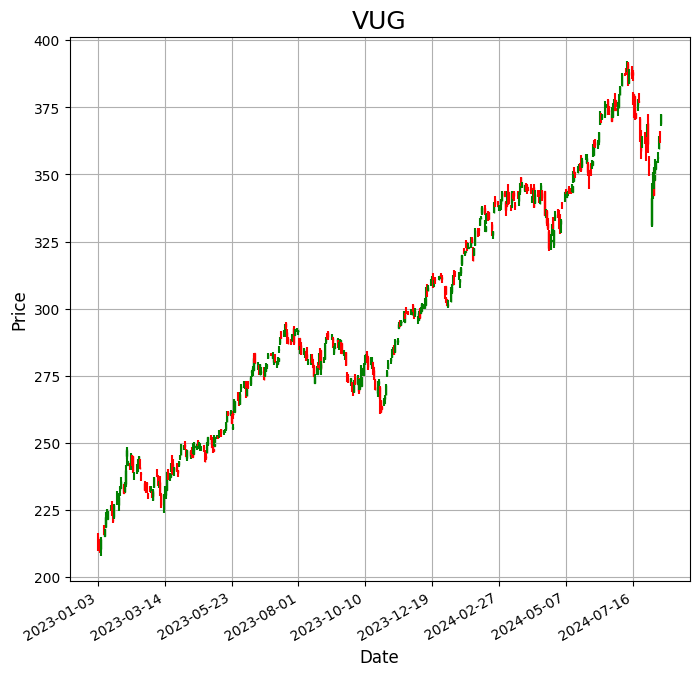

In [98]:
#Candlestick charts
for symbol in stocks_data['symbol'].unique():
    stock_data = stocks_data[stocks_data['symbol'] == symbol]
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_title(symbol, fontsize = 18)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)

    for val, stocks in stock_data.iterrows():
        if stocks['close'] >= stocks['open']:
            color = 'green'
            lower = stocks['open']
            height = stocks['close'] - stocks['open']
        else:
            color = 'red'
            lower = stocks['close']
            height = stocks['open'] - stocks['close']

        ax.add_patch(plt.Rectangle((matdates.date2num(stocks['date']) - 0.2, lower), 0.4, height, color=color))
        ax.vlines(matdates.date2num(stocks['date']), stocks['low'], stocks['high'], color=color)

    # Formatting the date on the x-axis
    ax.xaxis.set_major_formatter(matdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(matdates.WeekdayLocator(interval=10))
    fig.autofmt_xdate()
        
    plt.grid()
    plt.show()


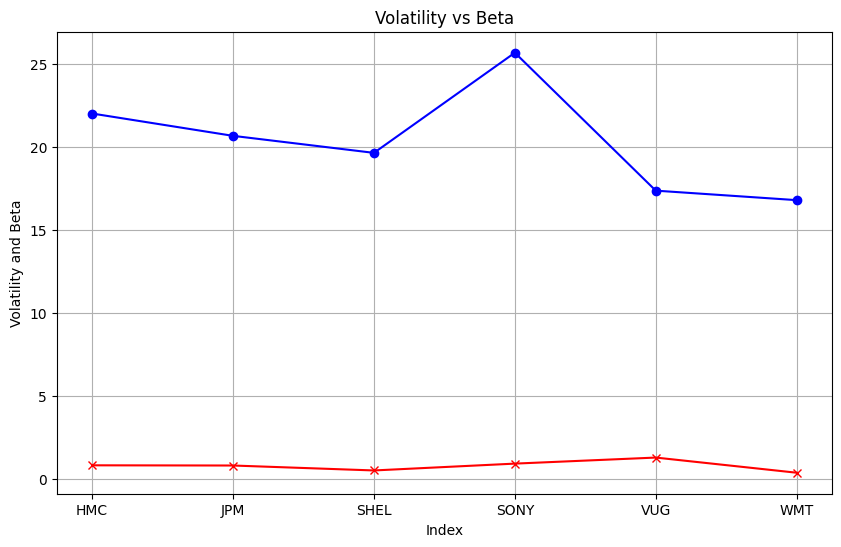

In [99]:
#Sharp ratio vs beta 
plt.figure(figsize=(10, 6))
plt.plot(individual_stock_portfolio.index, individual_stock_portfolio['volatility'], marker='o', color='blue', label='volatility')
plt.plot(individual_stock_portfolio.index, individual_stock_portfolio['beta'], marker='x', color='red', label='Beta')
plt.title('Volatility vs Beta')
plt.xlabel('Index')
plt.ylabel('Volatility and Beta')
plt.grid(True)
plt.show()

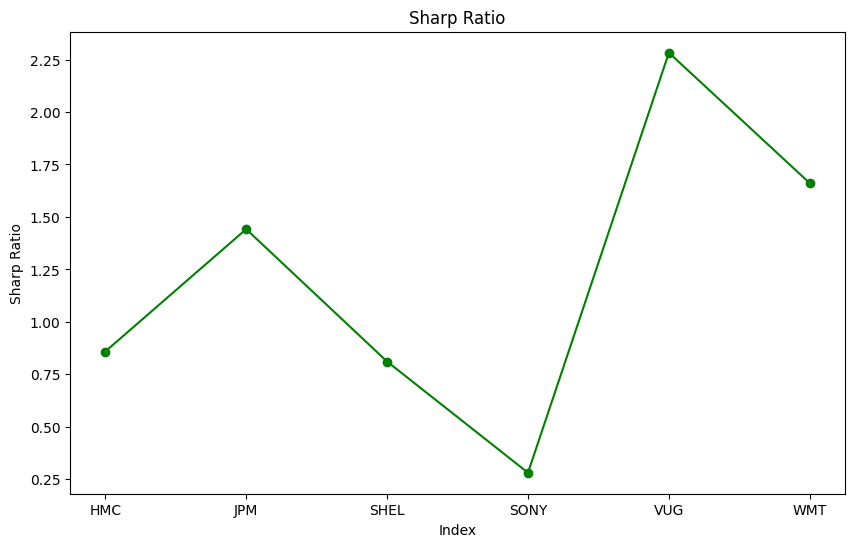

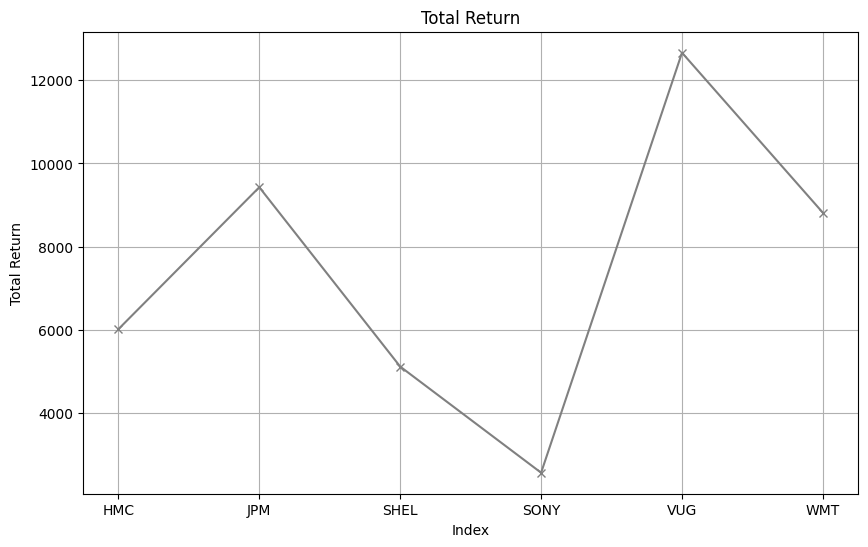

In [100]:
#Sharp ratio vs beta 
plt.figure(figsize=(10, 6))
plt.plot(individual_stock_portfolio.index, individual_stock_portfolio['sharp_ratio'], marker='o', color='green', label='Sharp Ratio')
plt.title('Sharp Ratio')
plt.xlabel('Index')
plt.ylabel('Sharp Ratio')
plt.figure(figsize=(10, 6))
plt.plot(individual_stock_portfolio.index, individual_stock_portfolio['total_return'], marker='x', color='gray', label='Total Return')
plt.title('Total Return')
plt.xlabel('Index')
plt.ylabel('Total Return')
plt.grid(True)
plt.show()